In [9]:
%matplotlib inline
import pandas as pd
import numpy as np
import random

import os

In [10]:
def predict_votes_by_qid(min_nb_choices=2, max_nb_choices=7, train_fraction = 0.8, max_t=None):
    os.system("rm -rf Train*")
    os.system("rm -rf Test*")
    os.system("rm -rf RSS*")   
    for choices in range(min_nb_choices,max_nb_choices):
        if max_t:
            votes = pd.DataFrame.from_csv('Qtnnet%d.csv'%choices)
            votes = votes[votes['Age_vot']<=max_t]
        else:
            votes = pd.DataFrame.from_csv('Qtnnet%d.csv'%choices)
        rand_idx = votes.groupby(['QuestionId']).apply(lambda df: pd.DataFrame({'Rand':
                                    [random.random()]})).reset_index(level=[0],drop=False)
        votes = pd.merge(votes,rand_idx,how='left',on=['QuestionId'])  
        train_idx = votes.Rand < train_fraction
        train = votes[train_idx]
        test = votes[~train_idx]
        train.to_csv('Train%dnnet.csv'%choices)
        test.to_csv('Test%dnnet.csv'%choices)
        os.system("Rscript predictMlogit.R Train%dnnet.csv Test%dnnet.csv RSS%d.csv"%tuple([choices]*3))  
    rss = pd.DataFrame()
    for choice in range(min_nb_choices,max_nb_choices):
        rss = rss.append(pd.DataFrame.from_csv('RSS%d.csv'%choice,sep=' '))
    os.system("rm -rf Train*")
    os.system("rm -rf Test*")
    os.system("rm -rf RSS*")
    return rss

def predict_votes_by_last(min_nb_choices=2, max_nb_choices=7):
    os.system("rm -rf Train*")
    os.system("rm -rf Test*")
    os.system("rm -rf RSS*")
    get_last = lambda df: pd.DataFrame(dict(zip(df.iloc[-1].index,[[e] for e in df.iloc[-1].values])))
    sort_and_tail = lambda df: get_last(df.sort_values(by=['Age_vot']))
    votes = pd.DataFrame.from_csv('QtnnetAll.csv')
    train = votes.groupby(['QuestionId']).apply(lambda df: df.sort_values(by=['Age_vot']).iloc[:-1]).reset_index(drop=True)
    test = votes.groupby(['QuestionId']).apply(sort_and_tail).reset_index(drop=True)
    
    for choices in range(min_nb_choices, max_nb_choices):
        train[train.Ans_count==choices].to_csv('Train%dnnetLast.csv'%choices)
        test[test.Ans_count==choices].to_csv('Test%dnnetLast.csv'%choices)
        os.system("Rscript predictMlogit.R Train%dnnetLast.csv Test%dnnetLast.csv RSS%dLast.csv"%tuple([choices]*3))
    rss = pd.DataFrame()
    for choices in range(min_nb_choices,max_nb_choices):
        rss = rss.append(pd.DataFrame.from_csv('RSS%dLast.csv'%choices,sep=' '))
    os.system("rm -rf Train*")
    os.system("rm -rf Test*")
    os.system("rm -rf RSS*")
    return rss

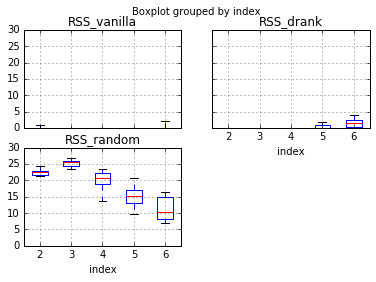

In [11]:
nb_iter = 10
rss_qid = pd.DataFrame()
for e in range(nb_iter):
    rss_qid = rss_qid.append(predict_votes_by_qid(max_t=10))
ff = rss_qid.reset_index(level=[0],drop=False).boxplot(by='index',column=['RSS_vanilla','RSS_drank','RSS_random'])

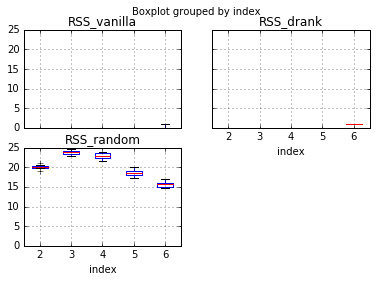

In [12]:
nb_iter = 10
rss_last = pd.DataFrame()
for e in range(nb_iter):
    rss_last = rss_last.append(predict_votes_by_last())
ff = rss_last.reset_index(level=[0],drop=False).boxplot(by='index',column=['RSS_vanilla','RSS_drank','RSS_random'])